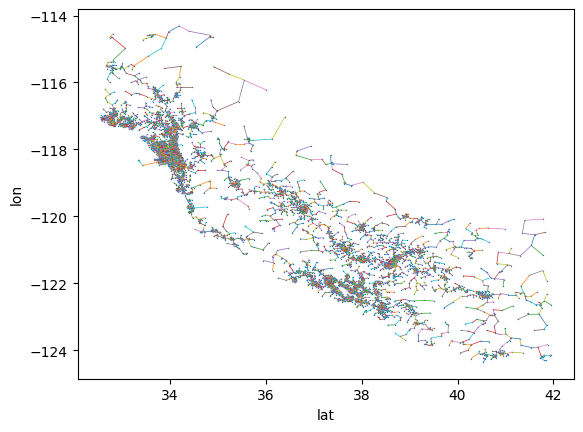

In [1]:
import csv
from typing import Final

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff

from common import mst_csv_path, vertices_csv_path, Edge, Vertex, centers_csv_path


MCDONALDS: Final[str] = "mcdonalds"
HOUSING: Final[str] = "housing"


def plot_mst(dataset: str):
    vertices = pd.read_csv(vertices_csv_path(dataset), names=["lat", "lon"])
    mst_edges = pd.read_csv(
        mst_csv_path(dataset), names=["p1x", "p1y", "p2x", "p2y", "w"]
    )

    ax = sns.scatterplot(data=vertices, x="lat", y="lon", s=1)
    for _, row in mst_edges.iterrows():
        ax.plot((row["p1x"], row["p2x"]), (row["p1y"], row["p2y"]), linewidth=0.5)


# plot_mst("mcdonalds")
plot_mst("housing")

<Axes: xlabel='lat', ylabel='lon'>

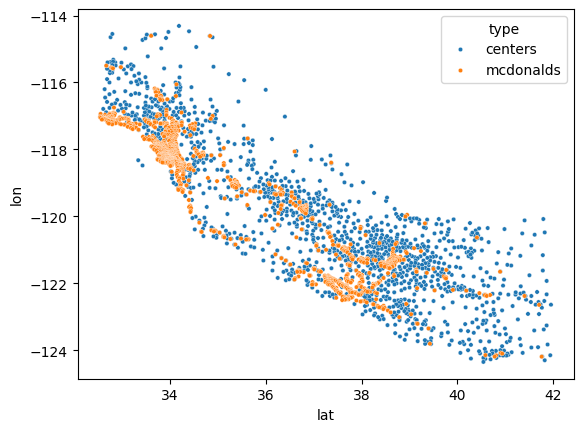

In [2]:
def parse_edge(row: tuple) -> Edge:
    p1x, p1y, p2x, p2y, w = map(float, row)
    return (((p1x, p1y), (p2x, p2y)), w)


def get_mst(dataset: str) -> list[Edge]:
    path = mst_csv_path(dataset)
    with open(path, newline="") as file:
        reader = csv.reader(file)
        return list(map(parse_edge, reader))


def parse_vertex(row: tuple) -> Vertex:
    x, y = map(float, row)
    return (x, y)


def get_vertices(dataset: str) -> list[Vertex]:
    path = vertices_csv_path(dataset)
    with open(path, newline="") as file:
        reader = csv.reader(file)
        return list(map(parse_vertex, reader))


def mst_to_clusters(dataset: str, k: int) -> list[list[Vertex]]:
    edges = get_mst(dataset)
    edges = sorted(edges, key=lambda e: e[1], reverse=True)
    edges = edges[k - 1 :]

    vertices = get_vertices(dataset)

    adj = {v: [] for v in vertices}
    for edge in edges:
        adj[edge[0][0]].append(edge[0][1])
        adj[edge[0][1]].append(edge[0][0])

    visited = set()

    def dfs(v: Vertex, component: list[Vertex]):
        visited.add(v)
        component.append(v)

        for n in adj[v]:
            if n not in visited:
                dfs(n, component)

    components = []

    for v in adj:
        if v not in visited:
            component = []
            dfs(v, component)
            components.append(component)

    return components


def find_centers(components: list[list[Vertex]]) -> list[Vertex]:
    def mean(cluster: list[Vertex]) -> Vertex:
        a = np.array(cluster)
        x, y = np.mean(a, axis=0)
        return (x, y)

    return list(map(mean, components))


def plot_clusters(clusters: list[list[Vertex]]):
    clusters = ((x, y, str(i)) for i, c in enumerate(clusters) for x, y in c)
    df = pd.DataFrame.from_records(clusters, columns=["lat", "lon", "cluster"])
    sns.scatterplot(data=df, x="lat", y="lon", hue="cluster", legend=False, s=10)


def plot_centers(centers: list[Vertex]):
    df = pd.DataFrame.from_records(centers, columns=["lat", "lon"])
    sns.scatterplot(data=df, x="lat", y="lon", s=10)


clusters = mst_to_clusters("housing", 1288)
centers = find_centers(clusters)
centers = pd.DataFrame.from_records(centers, columns=["lat", "lon"])
centers["type"] = "centers"
mac_v = pd.read_csv(vertices_csv_path("mcdonalds"), names=["lat", "lon"])
mac_v["type"] = "mcdonalds"
all = pd.concat([centers, mac_v])
sns.scatterplot(data=all, x="lat", y="lon", hue="type", s=10)

In [3]:
mac = get_vertices(MCDONALDS)
mac = np.array(mac)

clusters = mst_to_clusters(HOUSING, len(mac))
centers = find_centers(clusters)
centers = np.array(centers)

print(directed_hausdorff(mac, centers), directed_hausdorff(centers, mac))

(0.3421709748671465, 635, 419) (1.4910702569013972, 574, 823)


(0.6783808450022774, 140, 711) (1.1962194911536974, 1281, 823)


<Axes: xlabel='lat', ylabel='lon'>

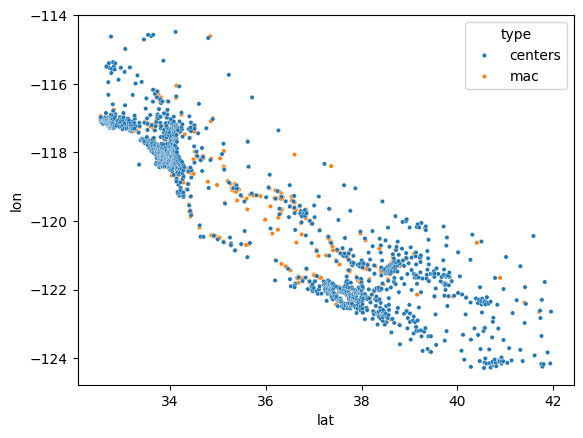

In [16]:
mac = pd.read_csv(vertices_csv_path(MCDONALDS), names=["lat", "lon"])
mac_np = mac.to_numpy()
mac["type"] = "mac"
centers = pd.read_csv(centers_csv_path(HOUSING), names=["lat", "lon"])
centers_np = centers.to_numpy()
centers["type"] = "centers"
all = pd.concat([mac, centers])
print(directed_hausdorff(mac_np, centers_np), directed_hausdorff(centers_np, mac_np))
sns.scatterplot(data=all, x="lat", y="lon", hue="type", hue_order=["centers","mac"], s=10)